In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
from tensorflow.keras.applications import VGG19

network = VGG19(include_top=False,weights="imagenet")

In [3]:
network.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

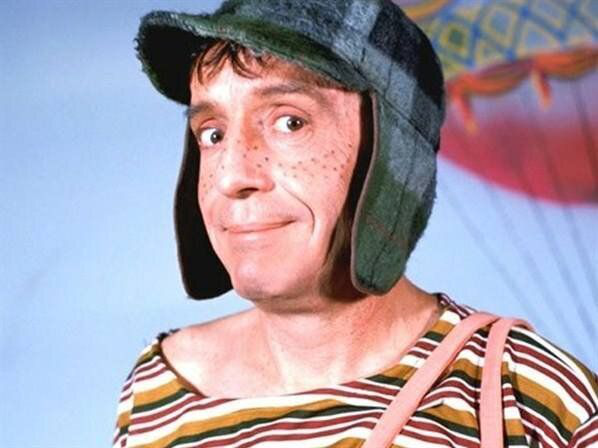

In [4]:
from tensorflow.keras.preprocessing.image import load_img

content_image = load_img("Images/chaves.jpeg")
content_image

In [5]:
content_image = tf.keras.preprocessing.image.img_to_array(content_image)

In [6]:
content_image.shape,content_image.min(),content_image.max()

((448, 598, 3), 0.0, 255.0)

In [7]:
content_image = content_image/255

In [8]:
content_image.shape,content_image.min(),content_image.max()

((448, 598, 3), 0.0, 1.0)

In [9]:
content_image = content_image[tf.newaxis,:]
content_image.shape

(1, 448, 598, 3)

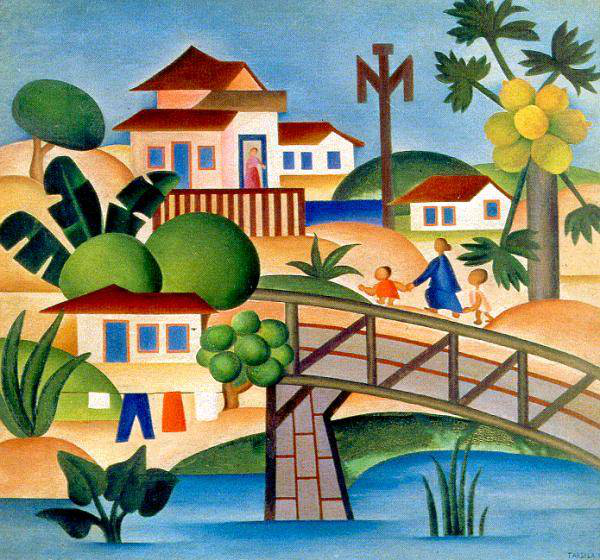

In [10]:
style_image = load_img("Images/tarsila_amaral.jpg")
style_image

In [11]:
style_image = tf.keras.preprocessing.image.img_to_array(style_image)
style_image = style_image/255
style_image = style_image[tf.newaxis,:]
style_image.shape

(1, 560, 600, 3)

In [12]:
content_layers = ["block4_conv2"]
style_layers = [f"block{i}_conv1" for i in range(1,6)]

In [13]:
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [14]:
from tensorflow.keras import Model

def vgg_layers(layer_names):
    vgg = VGG19(include_top=False,weights="imagenet")
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    network = Model(inputs=[vgg.input],outputs=outputs)
    return network

In [15]:
style_extractor = vgg_layers(style_layers)
style_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [16]:
style_outputs = style_extractor(style_image)

In [17]:
len(style_outputs)

5

In [18]:
for i in range(5):
    print(i,style_outputs[i].shape)

0 (1, 560, 600, 64)
1 (1, 280, 300, 128)
2 (1, 140, 150, 256)
3 (1, 70, 75, 512)
4 (1, 35, 37, 512)


In [19]:
def gram_matrix(layer_activation):
    result = tf.linalg.einsum("bijc,bijd->bcd",
                              layer_activation,
                              layer_activation)
    input_shape = tf.shape(layer_activation)
    num_locations = tf.cast(input_shape[1]*input_shape[2],tf.float32)
    return result/num_locations

In [20]:
gram_matrix(style_outputs[0])

<tf.Tensor: shape=(1, 64, 64), dtype=float32, numpy=
array([[[0.631103  , 0.2894989 , 0.2851721 , ..., 0.1051826 ,
         0.3695573 , 0.45017198],
        [0.2894989 , 0.24226913, 0.18415505, ..., 0.03151668,
         0.1960462 , 0.2170014 ],
        [0.2851721 , 0.18415505, 0.16761068, ..., 0.02775798,
         0.19407691, 0.22697584],
        ...,
        [0.1051826 , 0.03151668, 0.02775798, ..., 0.08261999,
         0.06934635, 0.06635001],
        [0.3695573 , 0.1960462 , 0.19407691, ..., 0.06934635,
         0.28692865, 0.31862432],
        [0.45017198, 0.2170014 , 0.22697584, ..., 0.06635001,
         0.31862432, 0.37485766]]], dtype=float32)>

In [21]:
class StyleContentModel(Model):
    def __init__(self,style_layers,content_layers):
        super().__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
    
    def call(self,inputs):
        inputs = inputs*255.0
        preprocess_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocess_input)
        style_outputs = outputs[:self.num_style_layers]
        content_outputs = outputs[self.num_style_layers:]
        
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        content_dict = {content_name:value for content_name,value in zip(self.content_layers,content_outputs)}
        style_dict = {style_name:value for style_name,value in zip(self.style_layers,style_outputs)}
        
        return {"content":content_dict,"style":style_dict}

In [22]:
extractor = StyleContentModel(style_layers,content_layers)
results = extractor(content_image)

In [23]:
for key,value in results.items():
    print(key,value.keys())

content dict_keys(['block4_conv2'])
style dict_keys(['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1'])


In [24]:
style_targets = extractor(style_image)["style"]
content_targets = extractor(content_image)["content"]

In [25]:
len(style_targets),len(content_targets)

(5, 1)

In [26]:
new_image = tf.Variable(content_image)

In [27]:
content_weight = 1
style_weight = 1000
optimizer = tf.optimizers.Adam(learning_rate=0.02)
epochs = 200
print_every = 20

Epoch 20, content loss: 468265.28125, style loss: 5456187392.0, total loss: 1091237969920.0


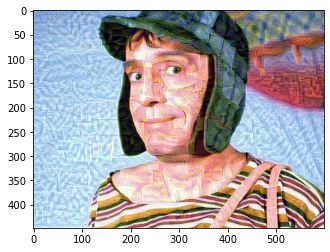

Epoch 40, content loss: 505748.3125, style loss: 1759480192.0, total loss: 351896535040.0


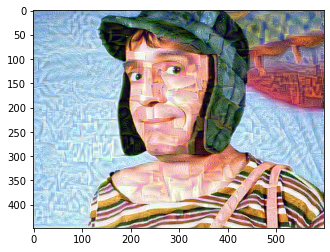

Epoch 60, content loss: 523903.375, style loss: 974403136.0, total loss: 194881159168.0


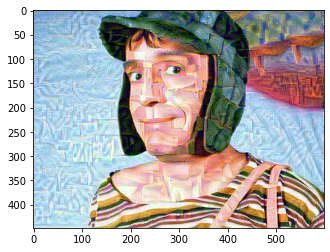

Epoch 80, content loss: 537275.3125, style loss: 693467264.0, total loss: 138694000640.0


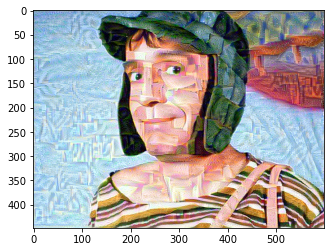

Epoch 100, content loss: 547516.3125, style loss: 550927552.0, total loss: 110186053632.0


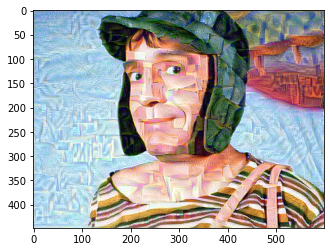

Epoch 120, content loss: 555675.1875, style loss: 462130432.0, total loss: 92426649600.0


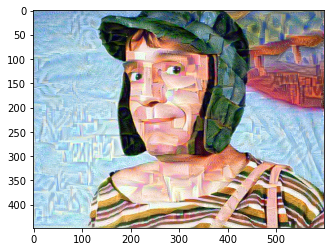

Epoch 140, content loss: 562490.375, style loss: 400050752.0, total loss: 80010715136.0


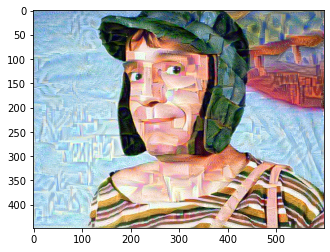

Epoch 160, content loss: 568500.4375, style loss: 353746208.0, total loss: 70749806592.0


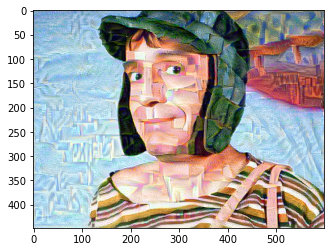

Epoch 180, content loss: 573949.3125, style loss: 317650176.0, total loss: 63530606592.0


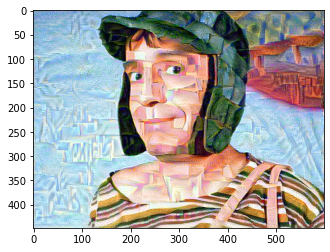

Epoch 200, content loss: 578858.9375, style loss: 288599904.0, total loss: 57720557568.0


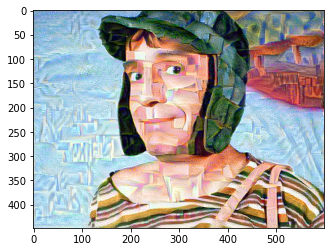

In [28]:
from sklearn.metrics import mean_absolute_error

for epoch in range(epochs):
    with tf.GradientTape() as tape:
        outputs = extractor(new_image)
        
        content_outputs = outputs["content"]
        style_outputs = outputs["style"]
        
        content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])
        style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])
        
        total_loss = content_loss * content_weight/num_content_layers + style_loss*style_weight/num_style_layers
    
    gradient = tape.gradient(total_loss,new_image)
    optimizer.apply_gradients([(gradient,new_image)])
    new_image.assign(tf.clip_by_value(new_image,0.0,1.0))
    if (epoch+1)%print_every==0:
        print(f"Epoch {epoch+1}, content loss: {content_loss}, style loss: {style_loss}, total loss: {total_loss}")
        plt.imshow(tf.squeeze(new_image,axis=0))
        plt.show()
        

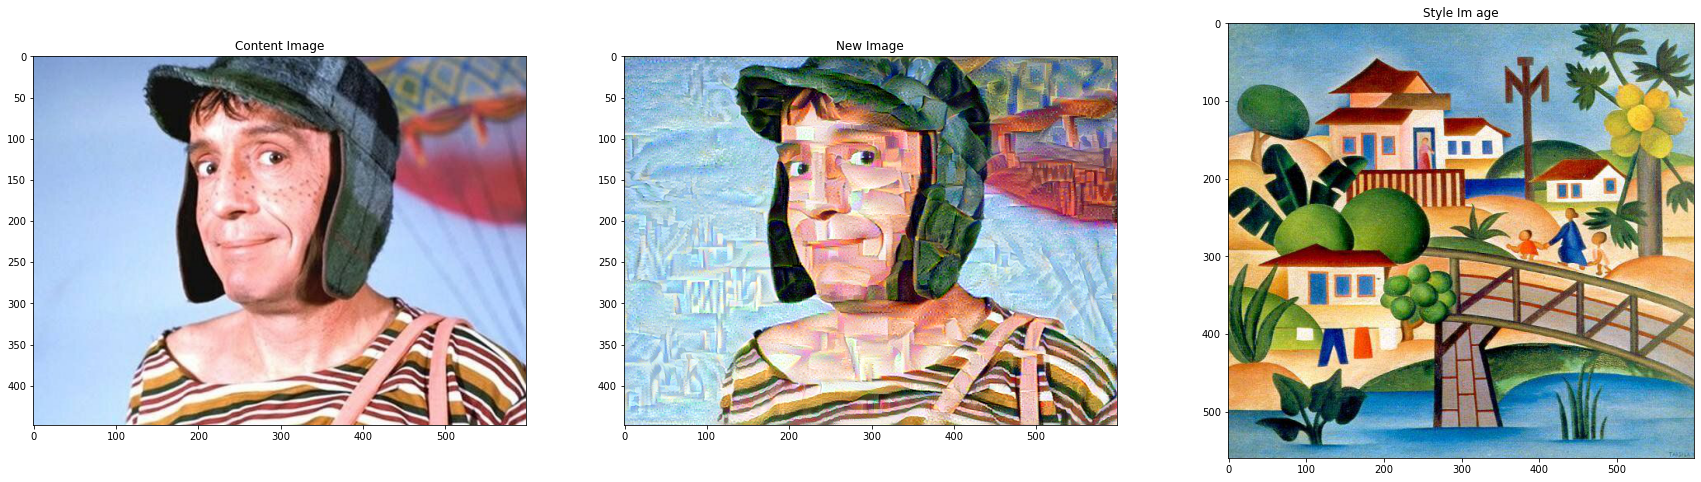

In [29]:
fig,axes = plt.subplots(1,3,figsize=(30,8))
axes.ravel()
axes[0].imshow(tf.squeeze(content_image,axis=0))
axes[0].set_title("Content Image")
axes[1].imshow(tf.squeeze(new_image,axis=0))
axes[1].set_title("New Image")
axes[2].imshow(tf.squeeze(style_image,axis=0))
axes[2].set_title("Style Im age")
plt.show()